In [2]:
#!/usr/bin/env python3
"""
fetch_speedo_osm_robust.py
Robust fetcher for Lahore Speedo / feeder bus routes and stops from OpenStreetMap (Overpass).
Outputs:
 - output_speedo/speedo_routes.geojson
 - output_speedo/speedo_stops.geojson
 - output_speedo/speedo_stops.csv
 - output_speedo/speedo_map.html
Notes:
 - The script tries to assemble route geometries when relations don't include 'geometry' by fetching member ways.
 - Respect Overpass rate limits. Use with care and do not hammer the API.
"""

import os
import time
import json
import math
import requests
import logging
from typing import Optional, List, Dict
from shapely.geometry import Point, LineString, shape, mapping
from shapely.ops import linemerge
import geopandas as gpd
import pandas as pd
import osmnx as ox
from tqdm import tqdm

# ---------- CONFIG ----------
OVERPASS_URL = "https://overpass-api.de/api/interpreter"
PLACE_NAME = "Lahore District, Pakistan"   # more reliable than "Lahore District, Pakistan"
OUT_DIR = "../data/osmnx/SpeedoData"
os.makedirs(OUT_DIR, exist_ok=True)
TIMEOUT = 180
SLEEP_BETWEEN_REQUESTS = 1.5  # polite delay between Overpass calls
MAX_RETRIES = 3

# Heuristics for Speedo / feeder
SPEEDO_ROUTE_REFS = set(str(i) for i in range(1, 41))
KEYWORDS = ["speedo", "feeder", "feeder bus", "speedo bus", "lahore feeder", "lahore speedo", "speedo-bus"]

# Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# ---------- HELPERS ----------
def contains_keyword(value, keywords=KEYWORDS) -> bool:
    if value is None:
        return False
    return any(k in str(value).lower() for k in keywords)

def overpass_post(query: str) -> dict:
    """Post a query to Overpass with retries and polite sleeps."""
    for attempt in range(1, MAX_RETRIES+1):
        try:
            resp = requests.post(OVERPASS_URL, data={"data": query}, timeout=TIMEOUT)
            resp.raise_for_status()
            time.sleep(SLEEP_BETWEEN_REQUESTS)
            return resp.json()
        except Exception as e:
            logging.warning("Overpass request failed (attempt %d/%d): %s", attempt, MAX_RETRIES, e)
            time.sleep(2 * attempt)
    raise RuntimeError("Overpass query failed after retries.")

def get_lahore_bbox(place_name: str = PLACE_NAME):
    logging.info("Resolving place polygon for '%s' via osmnx...", place_name)
    g = ox.geocode_to_gdf(place_name)
    if g.empty:
        raise SystemExit(f"Could not geocode place: {place_name}")
    geom = g.iloc[0].geometry
    minx, miny, maxx, maxy = geom.bounds
    # Overpass bbox format: south,west,north,east -> lat_min, lon_min, lat_max, lon_max
    bbox_str = f"{miny},{minx},{maxy},{maxx}"
    return bbox_str, (minx, miny, maxx, maxy)

def fetch_relations_bbox(bbox_str: str) -> dict:
    query = f"""
    [out:json][timeout:{TIMEOUT}];
    (
      relation["route"="bus"]({bbox_str});
    );
    out tags geom;
    """
    logging.info("Querying Overpass for bus relations...")
    return overpass_post(query)

def fetch_nodes_bbox(bbox_str: str) -> dict:
    query = f"""
    [out:json][timeout:{TIMEOUT}];
    (
      node["highway"="bus_stop"]({bbox_str});
      node["public_transport"="platform"]({bbox_str});
      way["public_transport"="platform"]({bbox_str});
    );
    out tags geom;
    """
    logging.info("Querying Overpass for stops (nodes + platform ways)...")
    return overpass_post(query)

def fetch_way_geometry(way_id: int) -> Optional[LineString]:
    """Fetch a way's geometry by id and return Shapely LineString (or None)."""
    query = f"""
    [out:json][timeout:{TIMEOUT}];
    way({way_id});
    out geom;
    """
    data = overpass_post(query)
    elems = data.get("elements", [])
    if not elems:
        return None
    way = elems[0]
    geom = way.get("geometry")
    if not geom:
        return None
    coords = [(pt["lon"], pt["lat"]) for pt in geom]
    return LineString(coords) if len(coords) >= 2 else None

def assemble_relation_geometry(rel: dict) -> Optional[LineString]:
    """If relation has 'geometry' use it. Otherwise, try to assemble from member ways."""
    # Use provided geometry if present
    geom_pts = rel.get("geometry")
    if geom_pts:
        coords = [(pt["lon"], pt["lat"]) for pt in geom_pts]
        if len(coords) >= 2:
            return LineString(coords)
    # Otherwise, attempt to fetch member ways (best-effort)
    members = rel.get("members", [])
    way_ids = [m.get("ref") for m in members if m.get("type") == "way" and m.get("role") in (None, "", "forward", "backward", "outer", "inner", "stop")]
    line_parts = []
    for wid in way_ids:
        try:
            wgeom = fetch_way_geometry(wid)
            if wgeom:
                line_parts.append(wgeom)
        except Exception as e:
            logging.debug("Failed fetching way %s: %s", wid, e)
    if not line_parts:
        return None
    try:
        merged = linemerge(line_parts)
        # linemerge may return LineString or MultiLineString; convert to LineString if possible
        if merged.is_empty:
            return None
        if merged.geom_type == "MultiLineString":
            # merge by concatenating coordinates (best-effort)
            coords = []
            for part in merged:
                coords.extend(list(part.coords))
            # remove consecutive duplicates
            coords_uniq = [coords[0]]
            for c in coords[1:]:
                if c != coords_uniq[-1]:
                    coords_uniq.append(c)
            return LineString(coords_uniq) if len(coords_uniq) >= 2 else None
        elif merged.geom_type == "LineString":
            return merged
    except Exception as e:
        logging.debug("linemerge failed: %s", e)
    return None

# ---------- MAIN ----------
def main():
    bbox_str, bbox_vals = get_lahore_bbox()
    minx, miny, maxx, maxy = bbox_vals
    relations_json = fetch_relations_bbox(bbox_str)
    stops_json = fetch_nodes_bbox(bbox_str)

    # Parse relations
    logging.info("Parsing relations...")
    relations = relations_json.get("elements", [])
    routes_records = []
    for rel in tqdm(relations, desc="relations"):
        tags = rel.get("tags", {}) or {}
        name = tags.get("name")
        ref = tags.get("ref")
        network = tags.get("network")
        operator = tags.get("operator")
        # Try to build geometry
        geom = assemble_relation_geometry(rel)
        routes_records.append({
            "osm_id": rel.get("id"),
            "name": name,
            "ref": ref,
            "network": network,
            "operator": operator,
            "tags": tags,
            "geometry": geom
        })

    # Create GeoDataFrame for routes - ensure geometry list provided
    geoms = [r["geometry"] if r["geometry"] is not None else None for r in routes_records]
    routes_gdf = gpd.GeoDataFrame(routes_records, geometry=geoms, crs="EPSG:4326")
    # Drop empty geometries (we keep metadata for these but cannot map their shape)
    routes_non_empty = routes_gdf[~routes_gdf.geometry.isna()].copy().reset_index(drop=True)
    logging.info("Total relations found: %d, with assembled geometry: %d", len(routes_gdf), len(routes_non_empty))

    # Parse stops: nodes and ways (convert ways to centroid if necessary)
    logging.info("Parsing stops...")
    stops_elements = stops_json.get("elements", [])
    stops_list = []
    for el in stops_elements:
        tags = el.get("tags", {}) or {}
        name = tags.get("name")
        if el.get("type") == "node":
            lat = el.get("lat")
            lon = el.get("lon")
            if lat is None or lon is None:
                continue
            geom = Point(lon, lat)
        elif el.get("type") == "way":
            # use centroid of way geometry if provided
            geom_pts = el.get("geometry")
            if geom_pts:
                coords = [(pt["lon"], pt["lat"]) for pt in geom_pts]
                try:
                    geom = LineString(coords).centroid
                except Exception:
                    continue
            else:
                continue
        else:
            continue
        stops_list.append({
            "osm_id": el.get("id"),
            "name": name,
            "tags": tags,
            "geometry": geom
        })

    stops_gdf = gpd.GeoDataFrame(stops_list, geometry=[s["geometry"] for s in stops_list], crs="EPSG:4326")
    logging.info("Total stops (nodes + platform ways) parsed: %d", len(stops_gdf))

    # ---------- Heuristic filtering for Speedo / feeder ----------
    logging.info("Applying heuristics to identify Speedo/Feeder routes...")
    def is_speedo_row(row):
        if contains_keyword(row.get("network")) or contains_keyword(row.get("operator")) or contains_keyword(row.get("name")):
            return True
        ref = row.get("ref")
        if ref:
            # extract numeric tokens
            tokens = [t for t in ''.join(ch if ch.isdigit() or ch==',' else ' ' for ch in str(ref)).split() if t]
            if any(t in SPEEDO_ROUTE_REFS for t in tokens):
                return True
        return False

    routes_non_empty["maybe_speedo"] = routes_non_empty.apply(is_speedo_row, axis=1)
    speedo_routes = routes_non_empty[routes_non_empty["maybe_speedo"]].copy()
    logging.info("Routes flagged as Speedo candidates: %d", len(speedo_routes))

    # Relax heuristic if none matched
    if speedo_routes.empty:
        logging.info("No candidates found with strict heuristic — relaxing criteria (look for 'feeder'/'lahore' in tags)...")
        routes_non_empty["maybe_speedo"] = routes_non_empty.apply(
            lambda r: contains_keyword(r.get("network")) or contains_keyword(r.get("operator")) or contains_keyword(r.get("name")) or ("feeder" in str(r.get("name","")).lower()) or ("lahore" in str(r.get("network","")).lower()),
            axis=1
        )
        speedo_routes = routes_non_empty[routes_non_empty["maybe_speedo"]].copy()
        logging.info("New candidate count: %d", len(speedo_routes))

    # ---------- Match stops to candidate routes by spatial proximity ----------
    logging.info("Matching stops to candidate routes by spatial proximity (50 m)...")
    speedo_stops = gpd.GeoDataFrame(columns=stops_gdf.columns, geometry=stops_gdf.geometry, crs=stops_gdf.crs)
    if not speedo_routes.empty and not stops_gdf.empty:
        # build buffers and check intersections (work in degrees; ~0.00045 deg ~ 50m)
        buffer_deg = 50 / 111320.0  # approximate degrees for 50 meters
        for idx, r in speedo_routes.iterrows():
            if r.geometry is None:
                continue
            buf = r.geometry.buffer(buffer_deg)
            matched = stops_gdf[stops_gdf.geometry.within(buf)]
            if not matched.empty:
                speedo_stops = pd.concat([speedo_stops, matched])
        # add stops whose name includes 'speedo'
        speedo_named = stops_gdf[stops_gdf["name"].fillna("").str.contains("speedo", case=False, na=False)]
        if not speedo_named.empty:
            speedo_stops = pd.concat([speedo_stops, speedo_named])
        # deduplicate
        if not speedo_stops.empty:
            speedo_stops = speedo_stops.drop_duplicates(subset=["osm_id"]).reset_index(drop=True)

    logging.info("Stops matched to candidates (final): %d", 0 if speedo_stops.empty else len(speedo_stops))

    # ---------- Save outputs ----------
    routes_out_path = os.path.join(OUT_DIR, "speedo_routes.geojson")
    stops_out_path = os.path.join(OUT_DIR, "speedo_stops.geojson")
    stops_csv_path = os.path.join(OUT_DIR, "speedo_stops.csv")

    if not speedo_routes.empty:
        speedo_routes.to_file(routes_out_path, driver="GeoJSON")
        logging.info("Saved candidate routes to %s", routes_out_path)
    else:
        logging.info("No candidate routes to save.")

    if not speedo_stops.empty:
        speedo_stops.to_file(stops_out_path, driver="GeoJSON")
        df_stops = speedo_stops.copy()
        df_stops["lon"] = df_stops.geometry.x
        df_stops["lat"] = df_stops.geometry.y
        df_stops[["osm_id", "name", "lat", "lon"]].to_csv(stops_csv_path, index=False)
        logging.info("Saved candidate stops to %s and CSV to %s", stops_out_path, stops_csv_path)
    else:
        logging.info("No candidate stops to save.")

    # ---------- Folium map ----------
    logging.info("Creating Folium map...")
    center_lat = (miny + maxy) / 2
    center_lon = (minx + maxx) / 2
    import folium
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    if not speedo_routes.empty:
        for _, r in speedo_routes.iterrows():
            coords = list(r.geometry.coords)
            coords_latlon = [(lat, lon) for lon, lat in coords]
            folium.PolyLine(coords_latlon, weight=4, opacity=0.7, popup=str(r.get("name"))).add_to(m)

    if not speedo_stops.empty:
        for _, s in speedo_stops.iterrows():
            folium.CircleMarker([s.geometry.y, s.geometry.x], radius=4, popup=str(s.get("name")), fill=True).add_to(m)

    map_path = os.path.join(OUT_DIR, "speedo_map.html")
    m.save(map_path)
    logging.info("Interactive map saved to %s", map_path)
    logging.info("Done.")


main()


2025-11-13 10:46:04,465 [INFO] Resolving place polygon for 'Lahore District, Pakistan' via osmnx...


2025-11-13 10:46:04,484 [INFO] Querying Overpass for bus relations...
2025-11-13 10:46:11,160 [WARNING] Overpass request failed (attempt 1/3): 504 Server Error: Gateway Timeout for url: https://overpass-api.de/api/interpreter
2025-11-13 10:46:15,634 [INFO] Querying Overpass for stops (nodes + platform ways)...
2025-11-13 10:46:18,810 [INFO] Parsing relations...
relations: 0it [00:00, ?it/s]
2025-11-13 10:46:18,818 [INFO] Total relations found: 0, with assembled geometry: 0
2025-11-13 10:46:18,818 [INFO] Parsing stops...
2025-11-13 10:46:18,821 [INFO] Total stops (nodes + platform ways) parsed: 106
2025-11-13 10:46:18,822 [INFO] Applying heuristics to identify Speedo/Feeder routes...
2025-11-13 10:46:18,823 [INFO] Routes flagged as Speedo candidates: 0
2025-11-13 10:46:18,823 [INFO] No candidates found with strict heuristic — relaxing criteria (look for 'feeder'/'lahore' in tags)...
2025-11-13 10:46:18,825 [INFO] New candidate count: 0
2025-11-13 10:46:18,826 [INFO] Matching stops to ca

In [3]:
lahore_str = "Lahore District, Pakistan"
boundary = ox.geocode_to_gdf(lahore_str)  # Get administrative Boundary for Lahore

# Central point
latitude = 31.4553688
longitude = 74.3008274

gdf = gpd.GeoDataFrame(  # create gdf w/ single point i.e Lahore's center
    {"geometry": [Point(longitude, latitude)]},
    crs="EPSG:4326",  # WGS84
)

gdf_utm = ox.projection.project_gdf(gdf) 

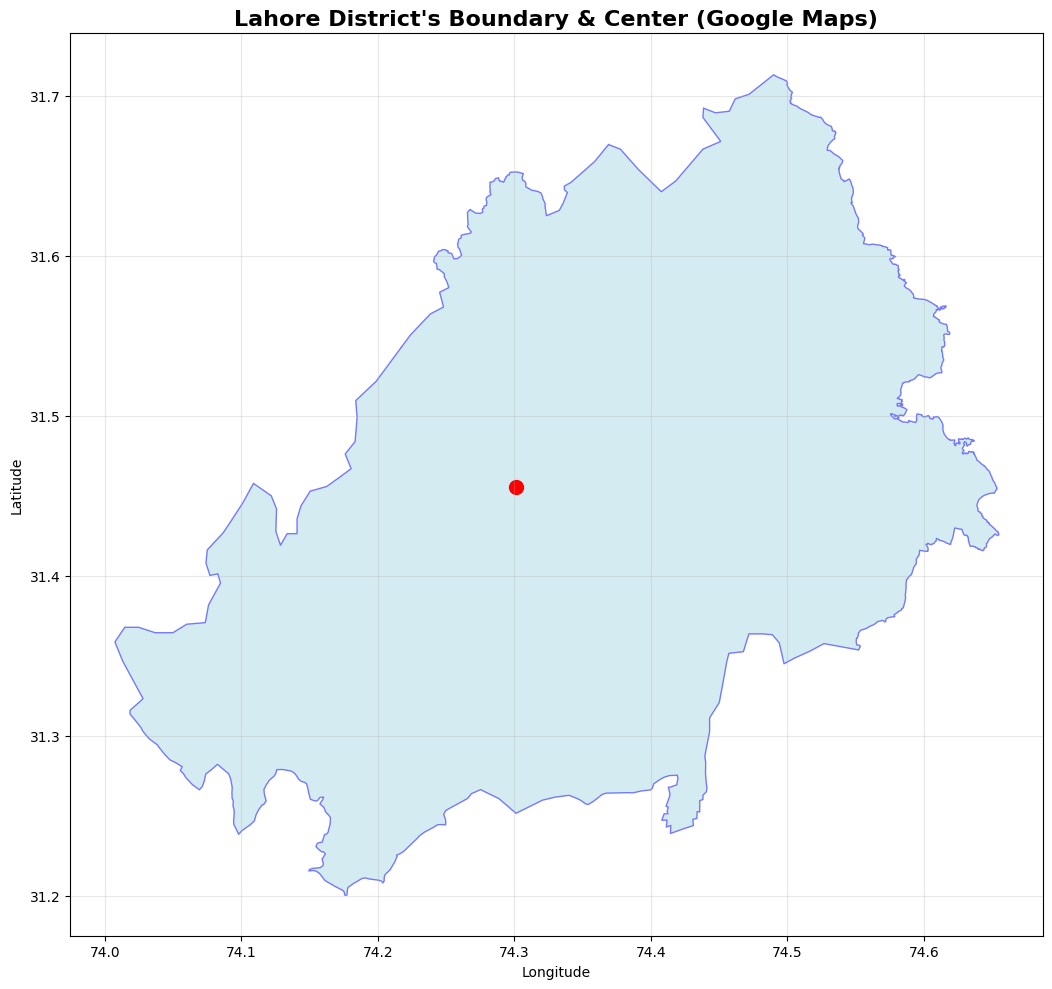

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 10))

boundary.plot(
    ax=ax, color="lightblue", edgecolor="blue", alpha=0.5, label="Lahore District"
)
gdf.plot(ax=ax, color="red", markersize=100)

ax.set_title(
    "Lahore District's Boundary & Center (Google Maps)",
    fontsize=16,
    fontweight="bold",
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()